In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
df = df.loc[df['Stats'].isin([5.e+08])]
df = df[~df['Crystal'].isin(['C_diamond', 'Cr', 'Cu', 'Fe', 'Ni', 'Ti'])]

print(df['Stats'].unique())
print(df['Crystal'].unique())

[5.e+08]
['Al' 'Al2O3_sapphire' 'Ba' 'Be' 'BeO' 'C_graphite' 'Cs' 'Cu2MnAl' 'Ga'
 'Ge' 'He4_hcp' 'I2' 'K' 'Mo' 'Na2Ca3Al2F14' 'Nb' 'Pb' 'Pt' 'Rb' 'Si' 'Tl'
 'UO2' 'Zn' 'Y2O3']


In [6]:
crystals = np.array(df['Crystal'].unique())

df['Crystal'].unique()

array(['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_graphite', 'Cs',
       'Cu2MnAl', 'Ga', 'Ge', 'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14',
       'Nb', 'Pb', 'Pt', 'Rb', 'Si', 'Tl', 'UO2', 'Zn', 'Y2O3'],
      dtype=object)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

Stats = df['Stats']

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

Diff_train, Diff_test, Stats_train, Stats_test, y_train, y_test = train_test_split(X, Stats, y_encoded, test_size=0.1, random_state=42)

In [8]:
import torch.nn.functional as F

# Преобразование матриц в numpy массив перед преобразованием в тензоры
Diff_train_matrices = np.array(Diff_train['Matrix'].tolist())
Diff_test_matrices = np.array(Diff_test['Matrix'].tolist())

Stats_train_matrices = np.array(Stats_train.tolist())
Stats_test_matrices = np.array(Stats_test.tolist())

# Преобразование данных в тензоры PyTorch
Diff_train_tensor = torch.FloatTensor(Diff_train_matrices)
Diff_train_tensor = Diff_train_tensor.unsqueeze(1)
#Diff_train_tensor = F.interpolate(Diff_train_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_train_tensor = Diff_train_tensor * 2.0 - 1.0
Stats_train_tensor = torch.FloatTensor(Stats_train_matrices)

y_train_tensor = torch.LongTensor(y_train)  # Используем LongTensor для целевых меток

Diff_test_tensor = torch.FloatTensor(Diff_test_matrices)
Diff_test_tensor = Diff_test_tensor.unsqueeze(1)
#Diff_test_tensor = F.interpolate(Diff_test_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_test_tensor = Diff_test_tensor * 2.0 - 1.0
Stats_test_tensor = torch.FloatTensor(Stats_test_matrices)

y_test_tensor = torch.LongTensor(y_test)

In [9]:
print(Diff_train_tensor.size())
print(Diff_test_tensor.size())

torch.Size([432, 1, 250, 480])
torch.Size([48, 1, 250, 480])


In [10]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Создание набора данных
train_dataset = TensorDataset(Diff_train_tensor, y_train_tensor)

test_dataset = TensorDataset(Diff_test_tensor, y_test_tensor)

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Инициализация одномерного Conditional ViT VAE

In [11]:
from vector_VAE import ViTVAE, vae_loss, vae_loss_free_bits

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration
model = ViTVAE(
    img_size=(250, 480),
    patch_size=(10, 16),  # 25x30 patches
    in_channels=1,
    embed_dim=512,
    depth=6,
    num_heads=8,
    num_classes=30,
    latent_dim=256,
    dropout=0.1,
    condition_type="add", # "add" "cross_attn"
    condition_mode="multi" # "single" "multi"
).to(device)

model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Multi_Add.pth"))
# model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Single_Add.pth"))
# model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Multi_CrossAtt.pth"))
# model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Single_CrossAtt.pth"))

model.to(device)

# fake batch
data = torch.randn(4, 1, 250, 480, device=device)
labels = torch.randint(0, 20, (4,), device=device)

recon_data, mean, logvar = model(data, labels)

print(recon_data.size(), mean.size(), logvar.size())

torch.Size([4, 1, 250, 480]) torch.Size([4, 256]) torch.Size([4, 256])


In [36]:
from tqdm import tqdm
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def denorm(x):
    return (x + 1) / 2

# Инициализируем метрики
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)  # data_range=1.0 для диапазона [0, 1]
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

psnr_values = []
ssim_values = []

model.eval()
with torch.no_grad():
    for _ in range(5):
        for data, labels in tqdm(train_loader):

            data = data.to(device)
            labels = labels.to(device)

            # Sample from prior distribution
            z = torch.randn(data.size(0), 256).to(device)
            generated = model.decoder(z, labels)

            # ---- denorm ----
            data_01 = denorm(data).clamp(0, 1)
            gen_01  = denorm(generated).clamp(0, 1)

            # ---- PSNR ----
            psnr_val = psnr_metric(data_01, gen_01)
            psnr_values.append(psnr_val.item())

            # ---- SSIM ----
            ssim_val = ssim_metric(data_01, gen_01)
            ssim_values.append(ssim_val.item())

N = len(psnr_values)
psnr_values = np.array(psnr_values)
ssim_values = np.array(ssim_values)

# Бутстрэп параметры
num_bootstraps = 1000  # Количество итераций; 1000–5000 для хорошей точности, но дольше считается

boot_PSNR = []
boot_SSIM = []
np.random.seed(42)  # Для воспроизводимости
for _ in tqdm(range(num_bootstraps)):
    # Семплируем с возвращением индексы
    indices = np.random.choice(N, size=N, replace=True)
    boot_preds_PSNR = psnr_values[indices]
    boot_preds_SSIM = ssim_values[indices]
    
    boot_PSNR.append(np.mean(boot_preds_PSNR))
    boot_SSIM.append(np.mean(boot_preds_SSIM))


# Финальные результаты
mean_PSNR = np.mean(boot_PSNR)
ci_low, ci_high = np.percentile(boot_PSNR, [2.5, 97.5])

print(f'Mean PSNR: {mean_PSNR}, db')
print(f'95% Confidence Interval: [{ci_low}, {ci_high}], db')

mean_SSIM = np.mean(boot_SSIM)
ci_low, ci_high = np.percentile(boot_SSIM, [2.5, 97.5])

print(f'Mean SSIM: {mean_SSIM}')
print(f'95% Confidence Interval: [{ci_low}, {ci_high}]')

  0%|          | 0/432 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13888.79it/s]

Mean PSNR: 14.049867568033271, db
95% Confidence Interval: [13.869271581018413, 14.233668183585008], db
Mean SSIM: 0.6261988898024377
95% Confidence Interval: [0.6204745050355861, 0.6323663465595908]


In [16]:
from peak_loss import Qwrapper, extract_peak_region
import torch
import numpy as np
from scipy.signal import find_peaks
import math

def find_peaks_for_batch(batch_DI,
                         height=0.05,
                         distance=10,
                         prominence=0.1,
                         width=5,
                         scale_factor=1.5,
                         default_window=15,
                         scale=False):

    batch_results = []

    for sample in batch_DI:
        d = sample["d"]
        I = sample["I"] / 4 if scale else sample["I"]

        peaks, properties = find_peaks(
            I,
            height=height,
            distance=distance,
            prominence=prominence,
            width=width
        )

        sample_peaks = []
        for peak_idx in peaks:
            d_window, I_window = extract_peak_region(
                d, I, peak_idx, peaks, properties,
                scale_factor, default_window
            )

            integral_intensity = float(np.sum(I_window))
            max_intensity = float(I[peak_idx])
            com = np.sum(d_window * I_window) / np.sum(I_window)

            # FWHM через scipy (индексное, но для относительной разности ок)
            if "widths" in properties:
                fwhm = float(properties["widths"][np.where(peaks == peak_idx)[0][0]])
            else:
                fwhm = np.nan

            sample_peaks.append({
                "d": float(d[peak_idx]),
                "d_com": float(com),
                "integral_intensity": integral_intensity,
                "max_intensity": max_intensity,
                "profile_d": d_window,
                "profile_I": I_window
            })

        batch_results.append(sample_peaks)

    return batch_results

def normalize_profile(I):
    s = np.sum(I)
    if s <= 0:
        return None
    return I / s

def resample_profile(d, I, d_center, x_ref):
    """
    d        : массив d
    I        : интенсивность
    d_center : центр пика
    x_ref    : общая относительная сетка
    """
    x = (d - d_center) / d_center
    I_norm = normalize_profile(I)
    if I_norm is None:
        return None

    return np.interp(x_ref, x, I_norm, left=0.0, right=0.0)

def emd_1d(p, q, dx):
    """
    p, q : нормированные 1D распределения (sum = 1)
    dx   : шаг сетки
    """
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    return np.sum(np.abs(cdf_p - cdf_q)) * dx

def emd_shape_loss(peak1, peak2,
                   x_ref,
                   eps=1e-12):
    """
    peak1, peak2 — словари пиков
    peak["d"], peak["profile_d"], peak["profile_I"]
    """

    p1 = resample_profile(
        peak1["profile_d"],
        peak1["profile_I"],
        peak1["d"],
        x_ref
    )
    p2 = resample_profile(
        peak2["profile_d"],
        peak2["profile_I"],
        peak2["d"],
        x_ref
    )

    if p1 is None or p2 is None:
        return 0.0

    # защита от численного мусора
    p1 = np.maximum(p1, 0)
    p2 = np.maximum(p2, 0)

    p1 /= (np.sum(p1) + eps)
    p2 /= (np.sum(p2) + eps)

    dx = x_ref[1] - x_ref[0]

    return emd_1d(p1, p2, dx)


# -------------------------------
# 3) Peak matching loss
# -------------------------------
def peak_matching_loss(batch_pred, batch_true, tol=0.05):
    total_loss_Iint = 0.0
    total_loss_Imax = 0.0
    total_loss_shape = 0.0

    for pred_peaks, true_peaks in zip(batch_pred, batch_true):

        if len(pred_peaks) == 0 or len(true_peaks) == 0:
            continue

        for p1 in pred_peaks:
            d1 = p1["d_com"]
            Iint1 = p1["integral_intensity"]
            Imax1 = p1["max_intensity"]

            p2 = min(true_peaks, key=lambda p: abs(p["d"] - d1))
            d2 = p2["d_com"]

            if abs(d1 - d2) > tol:
                continue

            Iint2 = p2["integral_intensity"]
            Imax2 = p2["max_intensity"]

            # 🔒 Безопасный лог
            Iint1_safe = max(Iint1, 0)
            Iint2_safe = max(Iint2, 0)
            Imax1_safe = max(Imax1, 0)
            Imax2_safe = max(Imax2, 0)

            # 1) Интегральная интенсивность
            loss_Iint = (math.log(Iint1_safe + 1) - math.log(Iint2_safe + 1))**2

            # 2) Максимальная интенсивность
            loss_Imax = (math.log(Imax1_safe + 1) - math.log(Imax2_safe + 1))**2

            x_ref = np.linspace(-0.03, 0.03, 64)
            loss_shape = emd_shape_loss(p1, p2, x_ref)

            total_loss_Iint += loss_Iint
            total_loss_Imax += loss_Imax
            total_loss_shape += loss_shape

    return {'Integral Intensity': total_loss_Iint,
            'Peak Intensity': total_loss_Imax,
            'shape': total_loss_shape,
            }




# ============================================================
# 4) Единый ООП-класс для всего пайплайна
# ============================================================
class DiffractionPipeline:
    def __init__(self,
                 fixed_centers_pred,
                 fixed_centers_true,
                 theta_range=(-170, 170),
                 L_range=(0.1, 10),
                 device="cuda"):

        self.device = device

        self.qw_pred = Qwrapper(theta_range, L_range, fixed_centers_pred, device)
        self.qw_true = Qwrapper(theta_range, L_range, fixed_centers_true, device)

    def __call__(self,
                 batch_pred_2d,
                 batch_true_2d,
                 peak_params_pred={},
                 peak_params_true={},
                 tol=0.05):

        # 1D проекции
        pred_DI = self.qw_pred.tensor_to_d(batch_pred_2d)
        true_DI = self.qw_true.tensor_to_d(batch_true_2d)

        # Пики
        pred_peaks = find_peaks_for_batch(pred_DI, **peak_params_pred)
        true_peaks = find_peaks_for_batch(true_DI, **peak_params_true)

        # Лосс
        return peak_matching_loss(pred_peaks, true_peaks, tol)

fixed_centers_hr = np.linspace(0.05318052, 7.49710258, 1241)
fixed_centers_lr = np.linspace(0.0546658, 7.49180085, 832)

pipe = DiffractionPipeline(
    fixed_centers_pred=fixed_centers_hr,
    fixed_centers_true=fixed_centers_lr,
    device=device
)

In [37]:
import torch
from tqdm import tqdm
import torch.nn.functional as F

def denorm(x):
    return (x + 1) / 2

# Validation
model.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
Shape_losses = []

with torch.no_grad():
    for data, labels in tqdm(train_loader):

        data = data.to(device)
        labels = labels.to(device)

        # Sample from prior distribution
        z = torch.randn(data.size(0), 256).to(device)
        generated = model.decoder(z, labels)

        # ---- denorm ----
        data_01 = denorm(data).clamp(0, 1)
        gen_01  = denorm(generated).clamp(0, 1)


        loss_peaks = pipe(
            batch_pred_2d=gen_01,     # предсказанная 2D дифракция
            batch_true_2d=data_01,     # ground-truth 2D
            peak_params_pred={"scale": False},
            peak_params_true={"scale": False},
            tol=0.05
        )

        Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
        Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
        Shape_losses.append(loss_peaks['shape'])

100%|██████████| 432/432 [00:04<00:00, 106.64it/s]


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Предполагаем, что у вас уже есть массивы:
# PSNRs, SSIMs, peak_losses - списки или numpy массивы

# 1. Расчет среднего и стандартного отклонения
def calculate_statistics(data, metric_name):
    """Вычисляет среднее и стандартное отклонение"""
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)  # ddof=1 для несмещенной оценки
    
    print(f"{metric_name}:")
    print(f"  Среднее: {mean_val:.4f}")
    print(f"  СКО: {std_val:.4f}")
    print(f"  Минимум: {np.min(data):.4f}")
    print(f"  Максимум: {np.max(data):.4f}")
    print(f"  Количество образцов: {len(data)}")
    print("-" * 40)
    
    return mean_val, std_val

# Вычисляем статистики для всех метрик
Integral_Intensity_mean, Integral_Intensity_std = calculate_statistics(Integral_Intensity_losses, 'Integral Intensity')
Peak_Intensity_mean, Peak_Intensity_std = calculate_statistics(Peak_Intensity_losses, 'Peak Intensity')
Shape_mean, Shape_std = calculate_statistics(Shape_losses, 'Shape loss')

Integral Intensity:
  Среднее: 3.3089
  СКО: 4.7252
  Минимум: 0.0000
  Максимум: 33.2550
  Количество образцов: 432
----------------------------------------
Peak Intensity:
  Среднее: 2.8938
  СКО: 3.7449
  Минимум: 0.0000
  Максимум: 20.5311
  Количество образцов: 432
----------------------------------------
Shape loss:
  Среднее: 0.0088
  СКО: 0.0054
  Минимум: 0.0000
  Максимум: 0.0289
  Количество образцов: 432
----------------------------------------


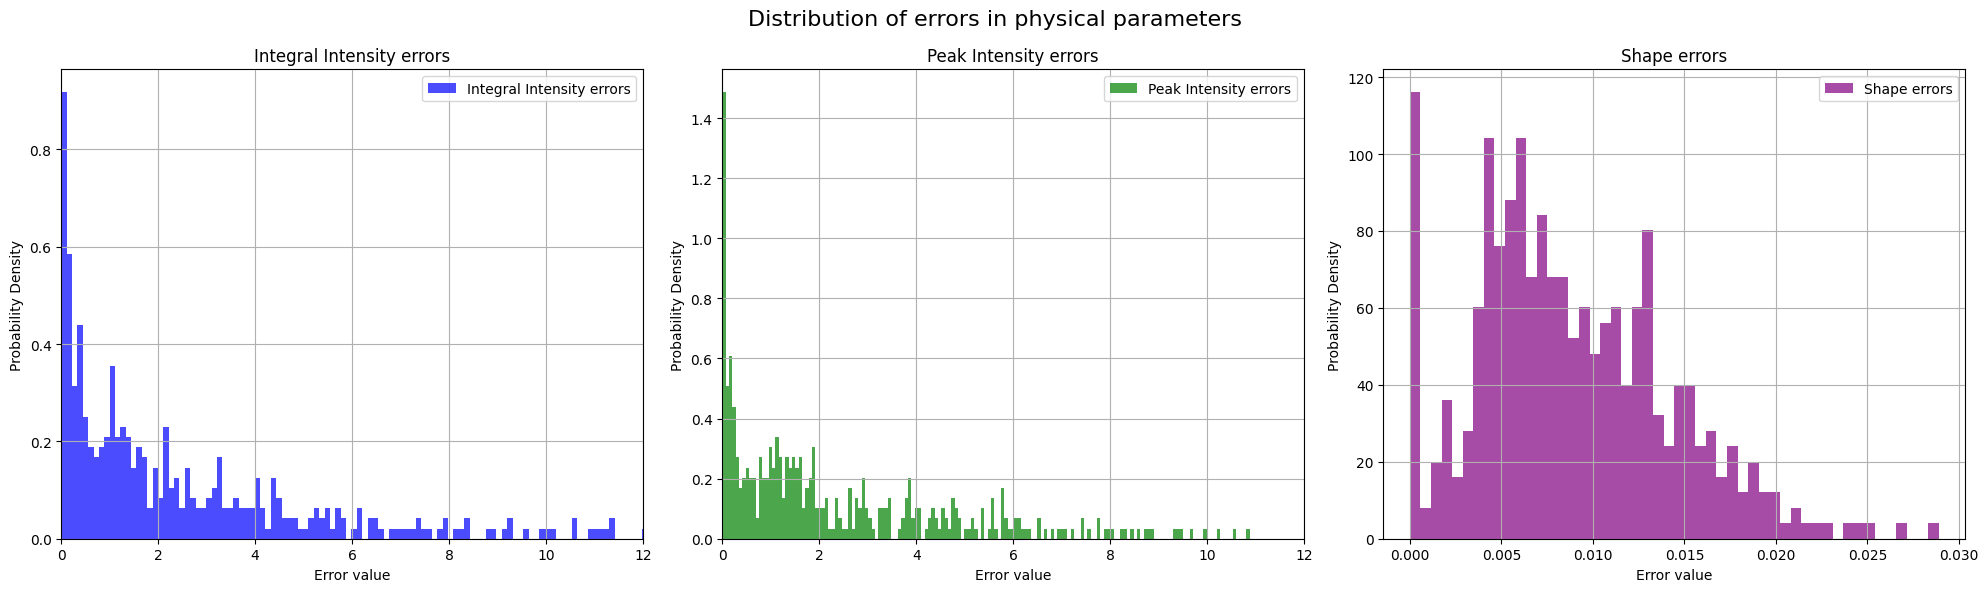

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'purple']  # Разные цвета для каждой гистограммы
bins = [300, 300, 50]
limits = [[0, 12], [0, 12], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [40]:
import json

with open("Результаты Поверхность/Conditional_Vector_ViT_VAE_Single_CrossAtt_physycal_metrics_results.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [42]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

pool = nn.MaxPool2d(kernel_size=2, stride=2).to(device)

def denorm(x):
    return (x + 1) / 2

# Validation
model.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
Shape_losses = []

with torch.no_grad():
    for data, labels in tqdm(train_loader):

        data = data.to(device)
        labels = labels.to(device)

        # ---- denorm ----
        data_01 = denorm(data).clamp(0, 1)
        pool_data_01 = pool(data_01)


        loss_peaks = pipe(
            batch_pred_2d=pool_data_01,     # предсказанная 2D дифракция
            batch_true_2d=data_01,     # ground-truth 2D
            peak_params_pred={"scale": False},
            peak_params_true={"scale": True},
            tol=0.05
        )

        Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
        Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
        Shape_losses.append(loss_peaks['shape'])

100%|██████████| 432/432 [00:01<00:00, 367.32it/s]


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Предполагаем, что у вас уже есть массивы:
# PSNRs, SSIMs, peak_losses - списки или numpy массивы

# 1. Расчет среднего и стандартного отклонения
def calculate_statistics(data, metric_name):
    """Вычисляет среднее и стандартное отклонение"""
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)  # ddof=1 для несмещенной оценки
    
    print(f"{metric_name}:")
    print(f"  Среднее: {mean_val:.4f}")
    print(f"  СКО: {std_val:.4f}")
    print(f"  Минимум: {np.min(data):.4f}")
    print(f"  Максимум: {np.max(data):.4f}")
    print(f"  Количество образцов: {len(data)}")
    print("-" * 40)
    
    return mean_val, std_val

# Вычисляем статистики для всех метрик
Integral_Intensity_mean, Integral_Intensity_std = calculate_statistics(Integral_Intensity_losses, 'Integral Intensity')
Peak_Intensity_mean, Peak_Intensity_std = calculate_statistics(Peak_Intensity_losses, 'Peak Intensity')
Shape_mean, Shape_std = calculate_statistics(Shape_losses, 'Shape loss')

Integral Intensity:
  Среднее: 0.6846
  СКО: 0.6384
  Минимум: 0.0000
  Максимум: 4.9584
  Количество образцов: 432
----------------------------------------
Peak Intensity:
  Среднее: 0.0721
  СКО: 0.1424
  Минимум: 0.0000
  Максимум: 2.6281
  Количество образцов: 432
----------------------------------------
Shape loss:
  Среднее: 0.0111
  СКО: 0.0057
  Минимум: 0.0000
  Максимум: 0.0284
  Количество образцов: 432
----------------------------------------


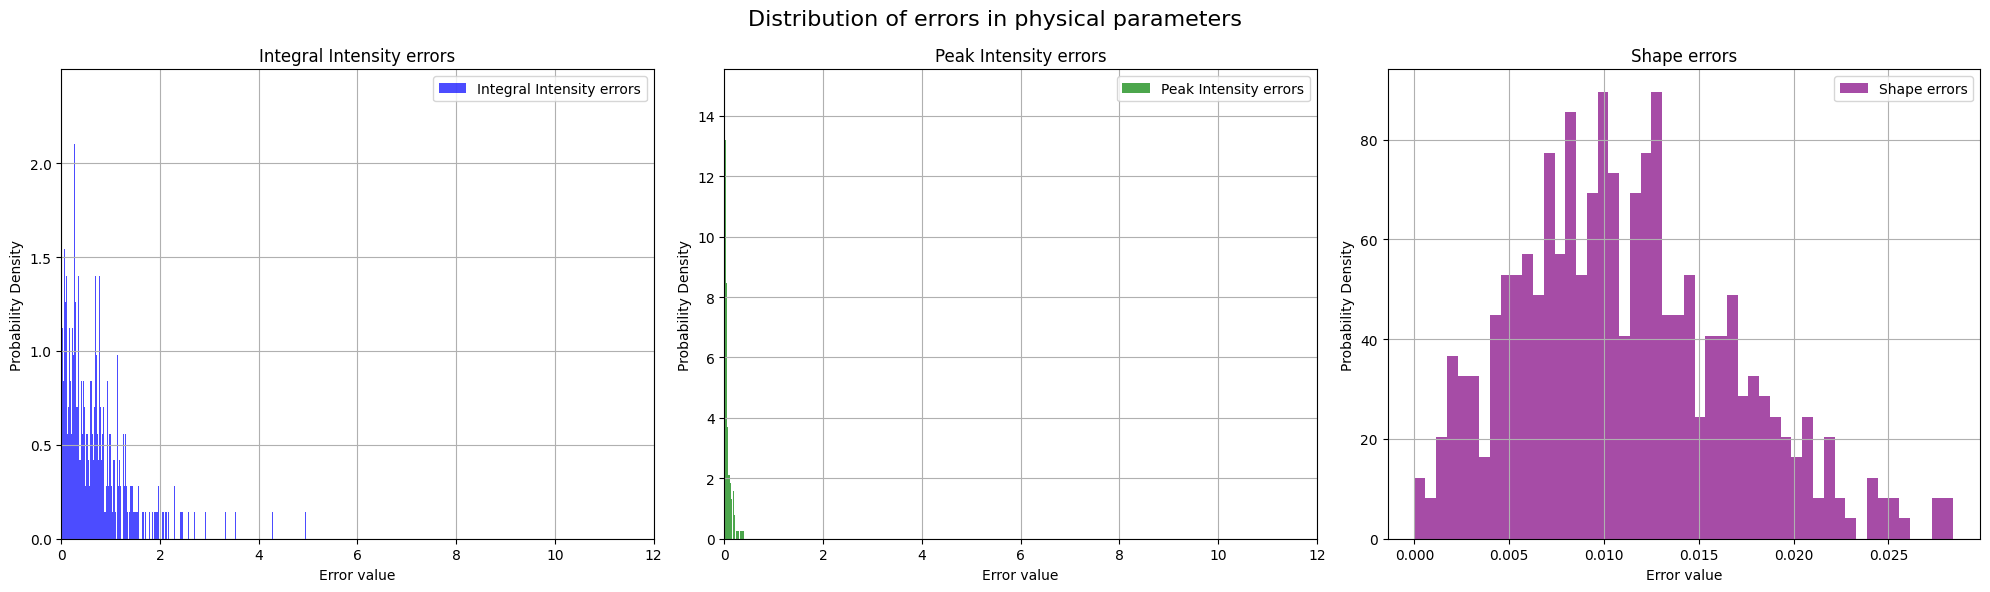

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'purple']  # Разные цвета для каждой гистограммы
bins = [300, 300, 50]
limits = [[0, 12], [0, 12], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [45]:
import json

with open("Результаты Поверхность/Pool_physycal_metrics_results.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [12]:
#array([1.e+07, 2.e+07, 5.e+07, 1.e+08, 2.e+08, 5.e+08])
maxStats = 5.e+08
minI = max(df['Pulce duration'].unique())

df_test = df.loc[((df['Stats'] == maxStats) & (df['Pulce duration'] == minI))]
df_test = df_test.reset_index(drop= True)

Crystal_tags = df_test['Crystal']

Crystal_tags_encoded = label_encoder.fit_transform(Crystal_tags)

Crystal_tags_encoded = torch.LongTensor(Crystal_tags_encoded)
Crystal_tags_encoded = Crystal_tags_encoded.to(device)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor * 2.0 - 1.0

df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())
print(Crystal_tags_encoded.size())

df_test_tensor = df_test_tensor.to(device)

torch.Size([24, 1, 250, 480])
torch.Size([24])


In [13]:
labels = torch.LongTensor([0, 1, 2, 3]).to(device)

model.eval()
with torch.no_grad():
    # Sample from prior distribution
    z = torch.randn(4, 256).to(device)

    generated = model.decoder(z, labels)

In [15]:
import torch

class Qwrapper:
    def __init__(self, theta_range=(-170, 170), L_range=(0.1, 10), fixed_centers=None, device="cuda"):
        self.theta_range = theta_range
        self.L_range = L_range
        self.device = device

        if fixed_centers is None:
            raise ValueError("Нужно передать фиксированные центры каналов d.")

        centers = torch.tensor(fixed_centers, dtype=torch.float32)
        self.centers = centers.to(device)

        # Строим границы каналов
        edges = torch.zeros(len(centers) + 1, dtype=torch.float32)

        edges[1:-1] = (centers[:-1] + centers[1:]) * 0.5
        edges[0] = centers[0] - (centers[1] - centers[0]) * 0.5
        edges[-1] = centers[-1] + (centers[-1] - centers[-2]) * 0.5

        self.edges = edges.to(device)


    def tensor_to_d(self, batch_tensor):
        if batch_tensor.dim() != 4:
            raise ValueError("Ожидается тензор размера [B, 1, H, W]")

        B, _, H, W = batch_tensor.shape
        batch_tensor = batch_tensor.to(self.device)

        # формируем theta и L (Правильно!)
        theta_deg = torch.linspace(self.theta_range[0], self.theta_range[1], W, device=self.device)
        L_vals = torch.linspace(self.L_range[0], self.L_range[1], H, device=self.device)

        theta_rad = torch.deg2rad(theta_deg)  # [W]

        # meshgrid правильно: (H, W)
        # L зависит от строки, theta зависит от столбца
        L_grid, theta_grid = torch.meshgrid(L_vals, theta_rad, indexing="ij")
        # теперь:
        # L_grid:     [H, W]
        # theta_grid: [H, W]

        # вычисляем d
        d_grid = L_grid / (2 * torch.sin(torch.abs(theta_grid) * 0.5))

        # маска d <= 7.5
        mask = d_grid <= 7.5  # [H, W]

        results = []

        for b in range(B):
            I_mat = batch_tensor[b, 0]  # [H, W]

            # применяем маску
            d_vals = d_grid[mask]       # [N]
            I_vals = I_mat[mask]        # [N]

            # определяем индекс канала
            idx = torch.bucketize(d_vals, self.edges) - 1

            I_summed = torch.zeros(len(self.centers), device=self.device)
            I_summed.scatter_add_(0, idx.clamp(0, len(I_summed) - 1), I_vals)

            results.append({
                "d": self.centers.detach().cpu().numpy(),
                "I": I_summed.detach().cpu().numpy()
            })

        return results


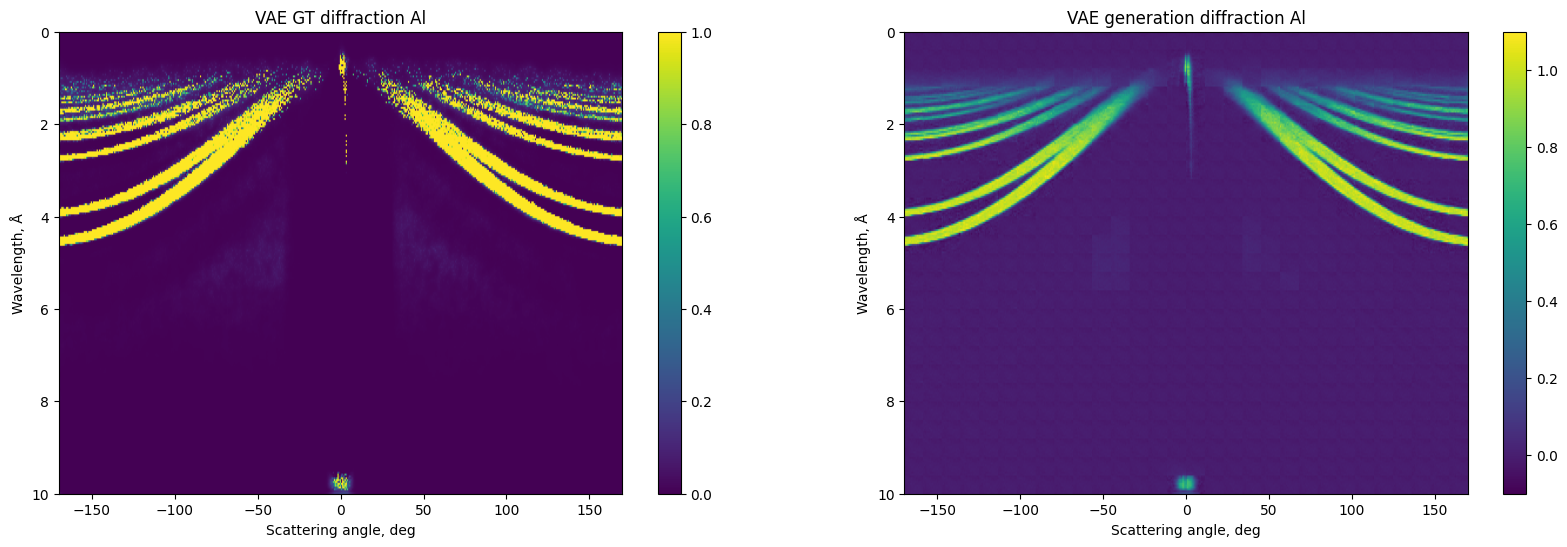

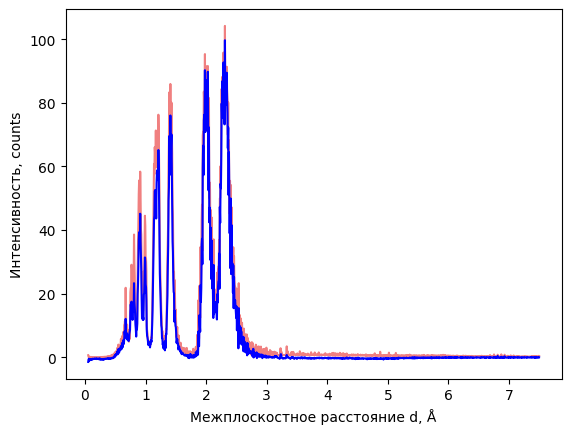

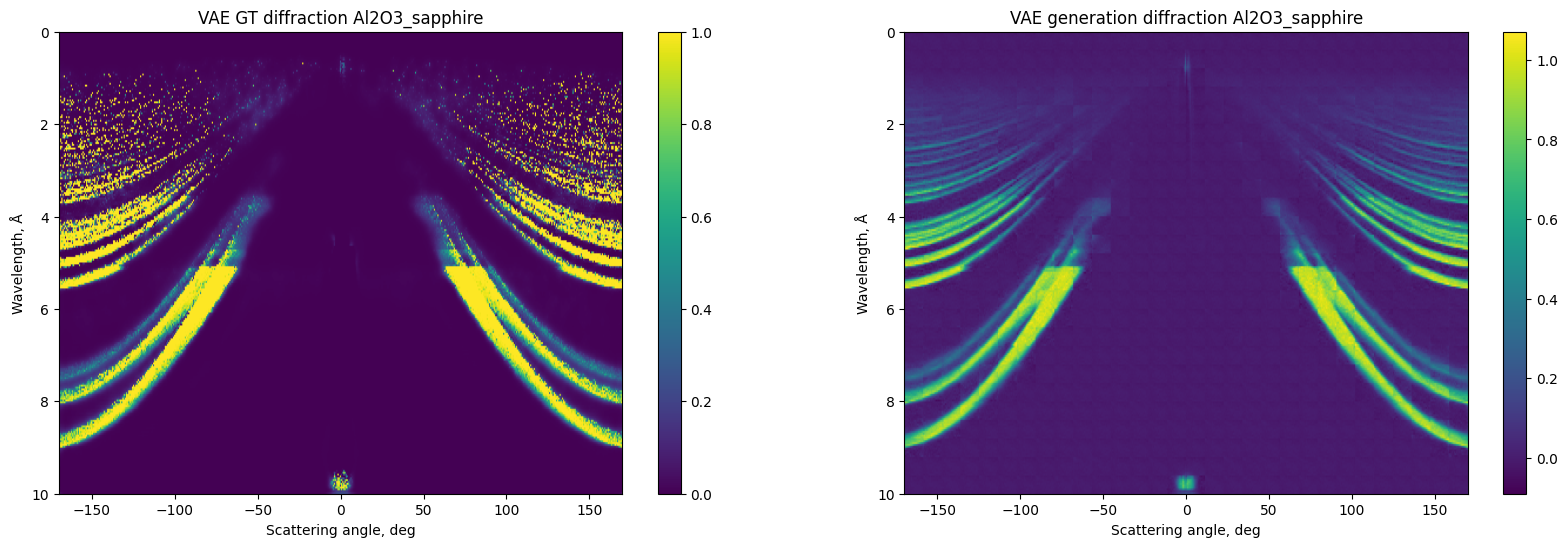

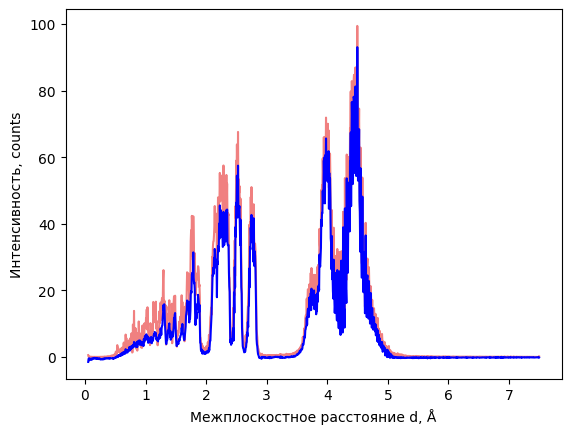

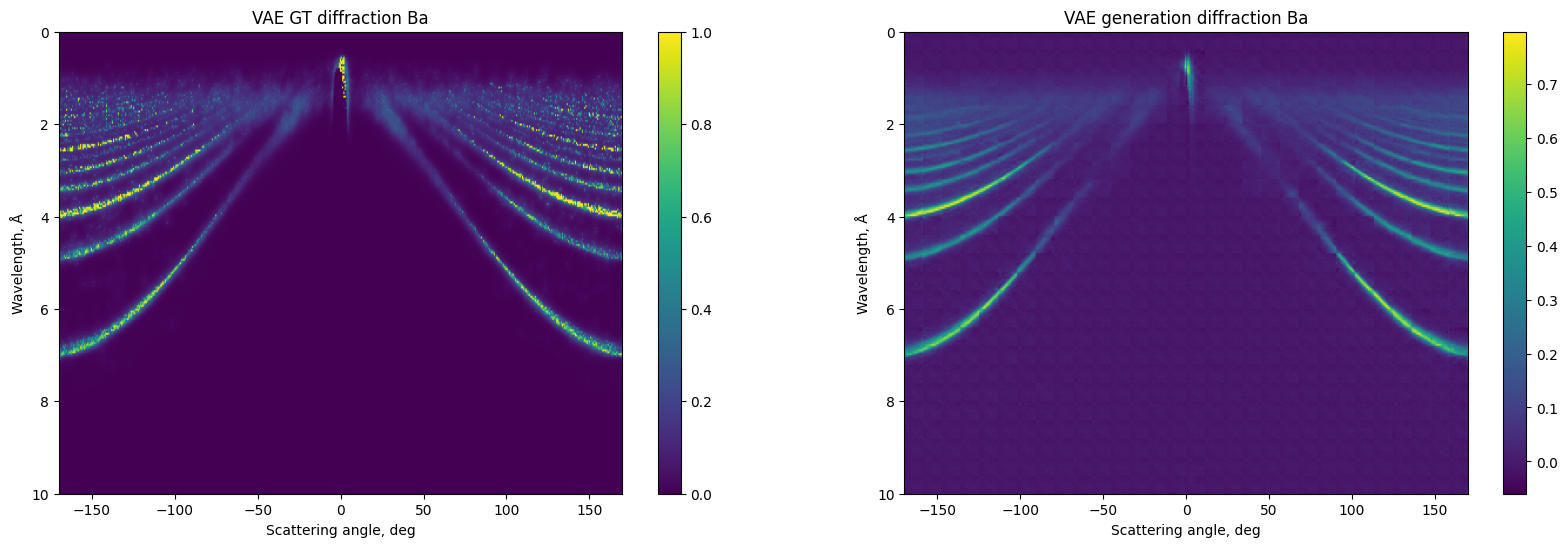

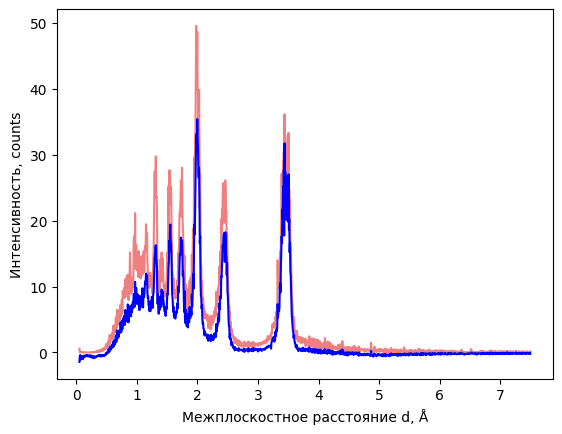

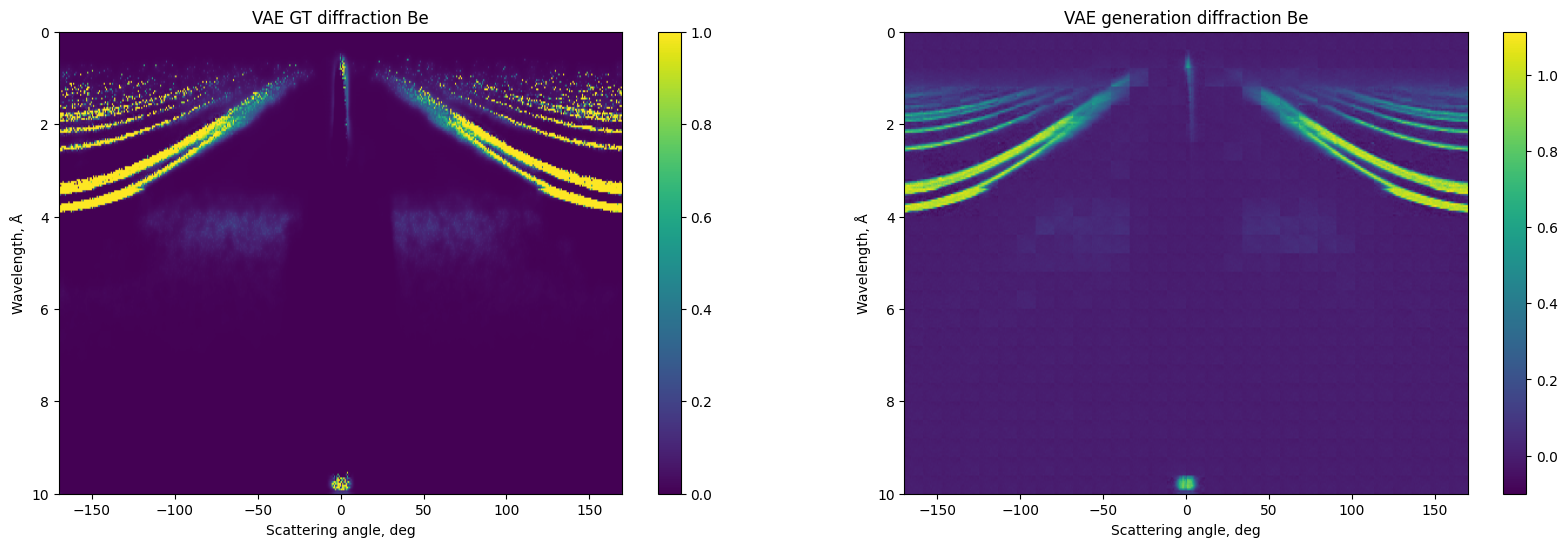

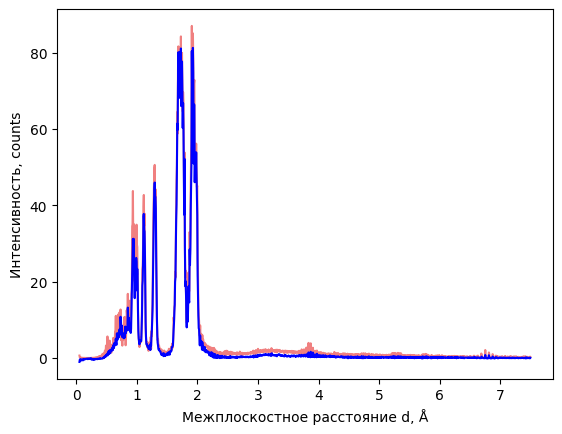

In [16]:
import matplotlib.pyplot as plt

def denorm(x):
    return (x + 1) / 2

fixed_centers = np.linspace(0.05318052, 7.49710258, 1241)

qw = Qwrapper(
    theta_range=(-170, 170),
    L_range=(0.1, 10),
    fixed_centers=fixed_centers,
    device = "cpu"
)

denorm_generated = denorm(generated)
denorm_df_test_tensor = denorm(df_test_tensor)

out_GT = qw.tensor_to_d(denorm_df_test_tensor)
out_generated = qw.tensor_to_d(denorm_generated)

generated_diffractions = denorm_generated.squeeze().cpu().numpy()
gt_diffractions = denorm_df_test_tensor.squeeze().cpu().numpy()


for i, (generated_diffraction, gt_diffraction) in enumerate(zip(generated_diffractions, gt_diffractions[:4])):
    # Создаем фигуру и оси
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Первый график
    im1 = ax1.imshow(gt_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax1.set_title(f"VAE GT diffraction {Crystal_tags.tolist()[i]}")
    ax1.set_xlabel('Scattering angle, deg')
    ax1.set_ylabel('Wavelength, Å')
    plt.colorbar(im1)

    # Первый график
    im2 = ax2.imshow(generated_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax2.set_title(f"VAE generation diffraction {Crystal_tags.tolist()[i]}")
    ax2.set_xlabel('Scattering angle, deg')
    ax2.set_ylabel('Wavelength, Å')
    plt.colorbar(im2)
    plt.show()


    plt.figure()
    plt.plot(out_GT[i]["d"], out_GT[i]["I"], label='Оригинальная дифракция', color='lightcoral')
    plt.plot(out_generated[i]["d"], out_generated[i]["I"], label='Сгенерированная дифракция', color='blue')
    plt.xlabel('Межплоскостное расстояние d, Å')
    plt.ylabel('Интенсивность, counts')


    # plt.savefig(f'VAE Results/{Crystal_tags.tolist()[i]} Diffraction VAE.jpg')

    plt.show()

C:\Users\neUral\AppData\Local\Temp\ipykernel_4348\2621591666.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


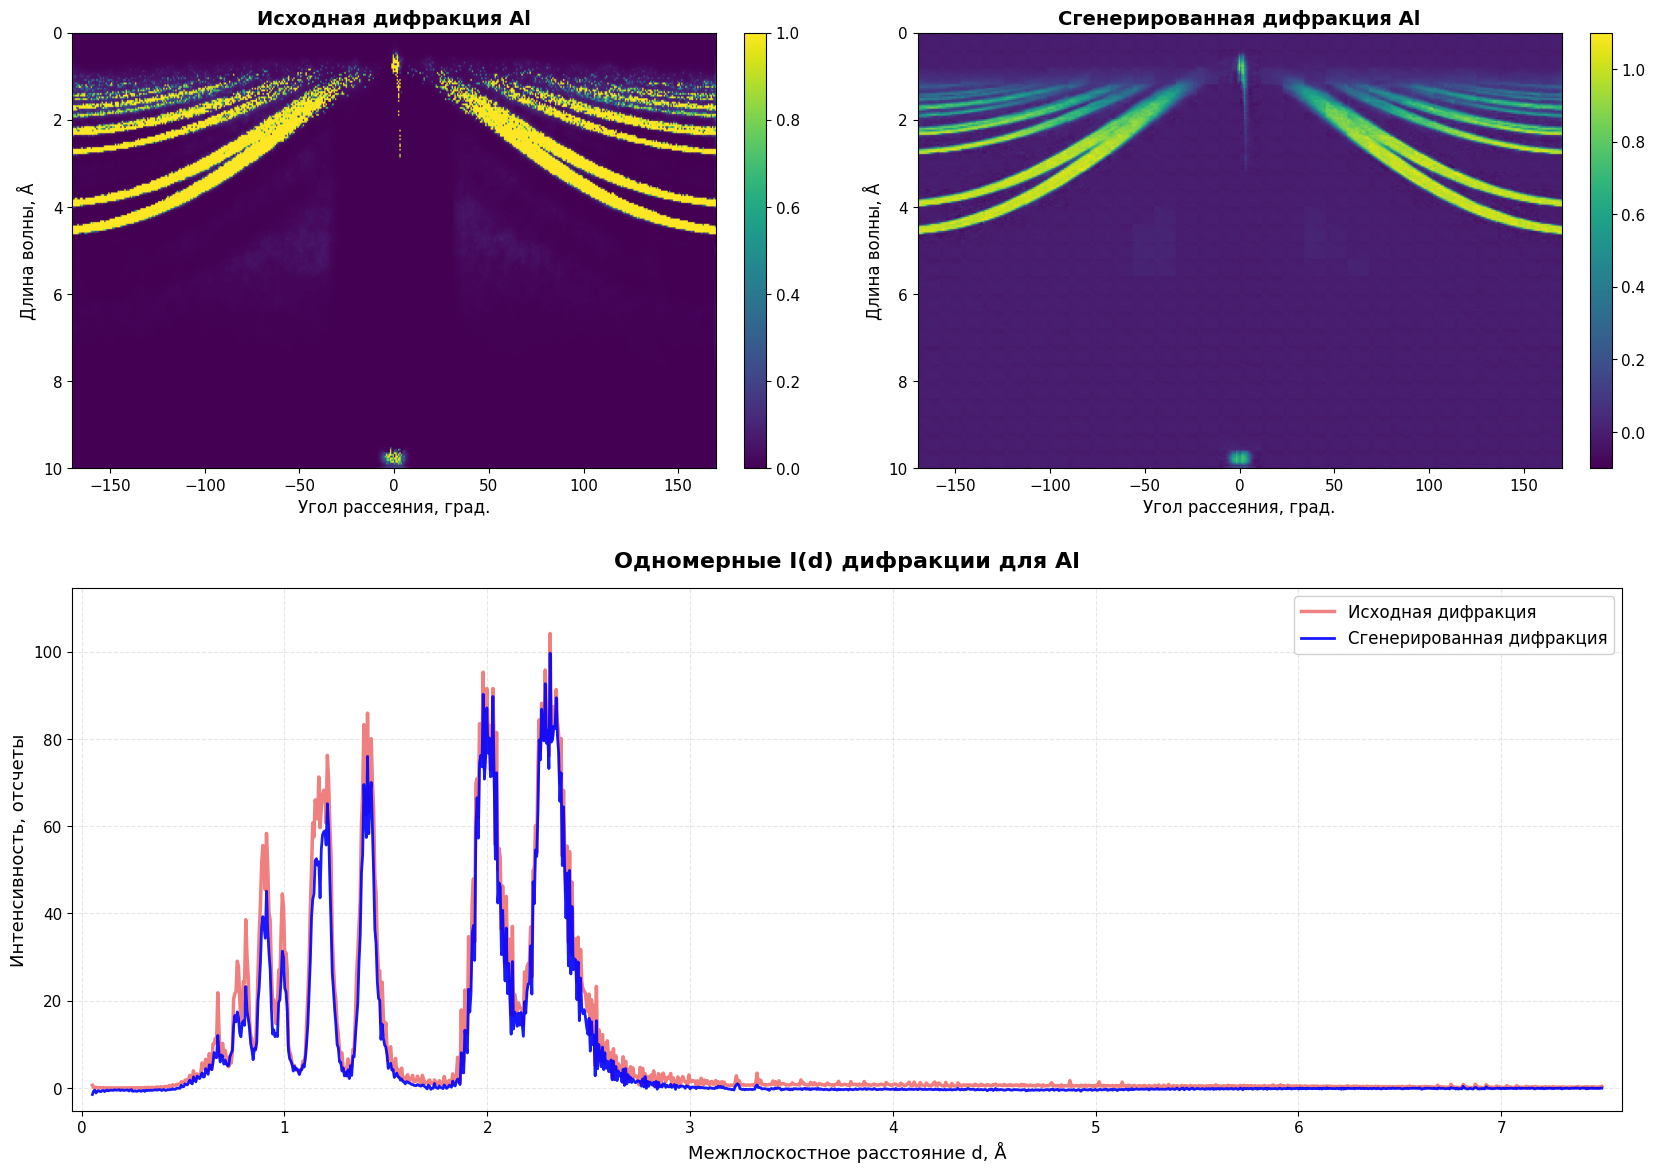

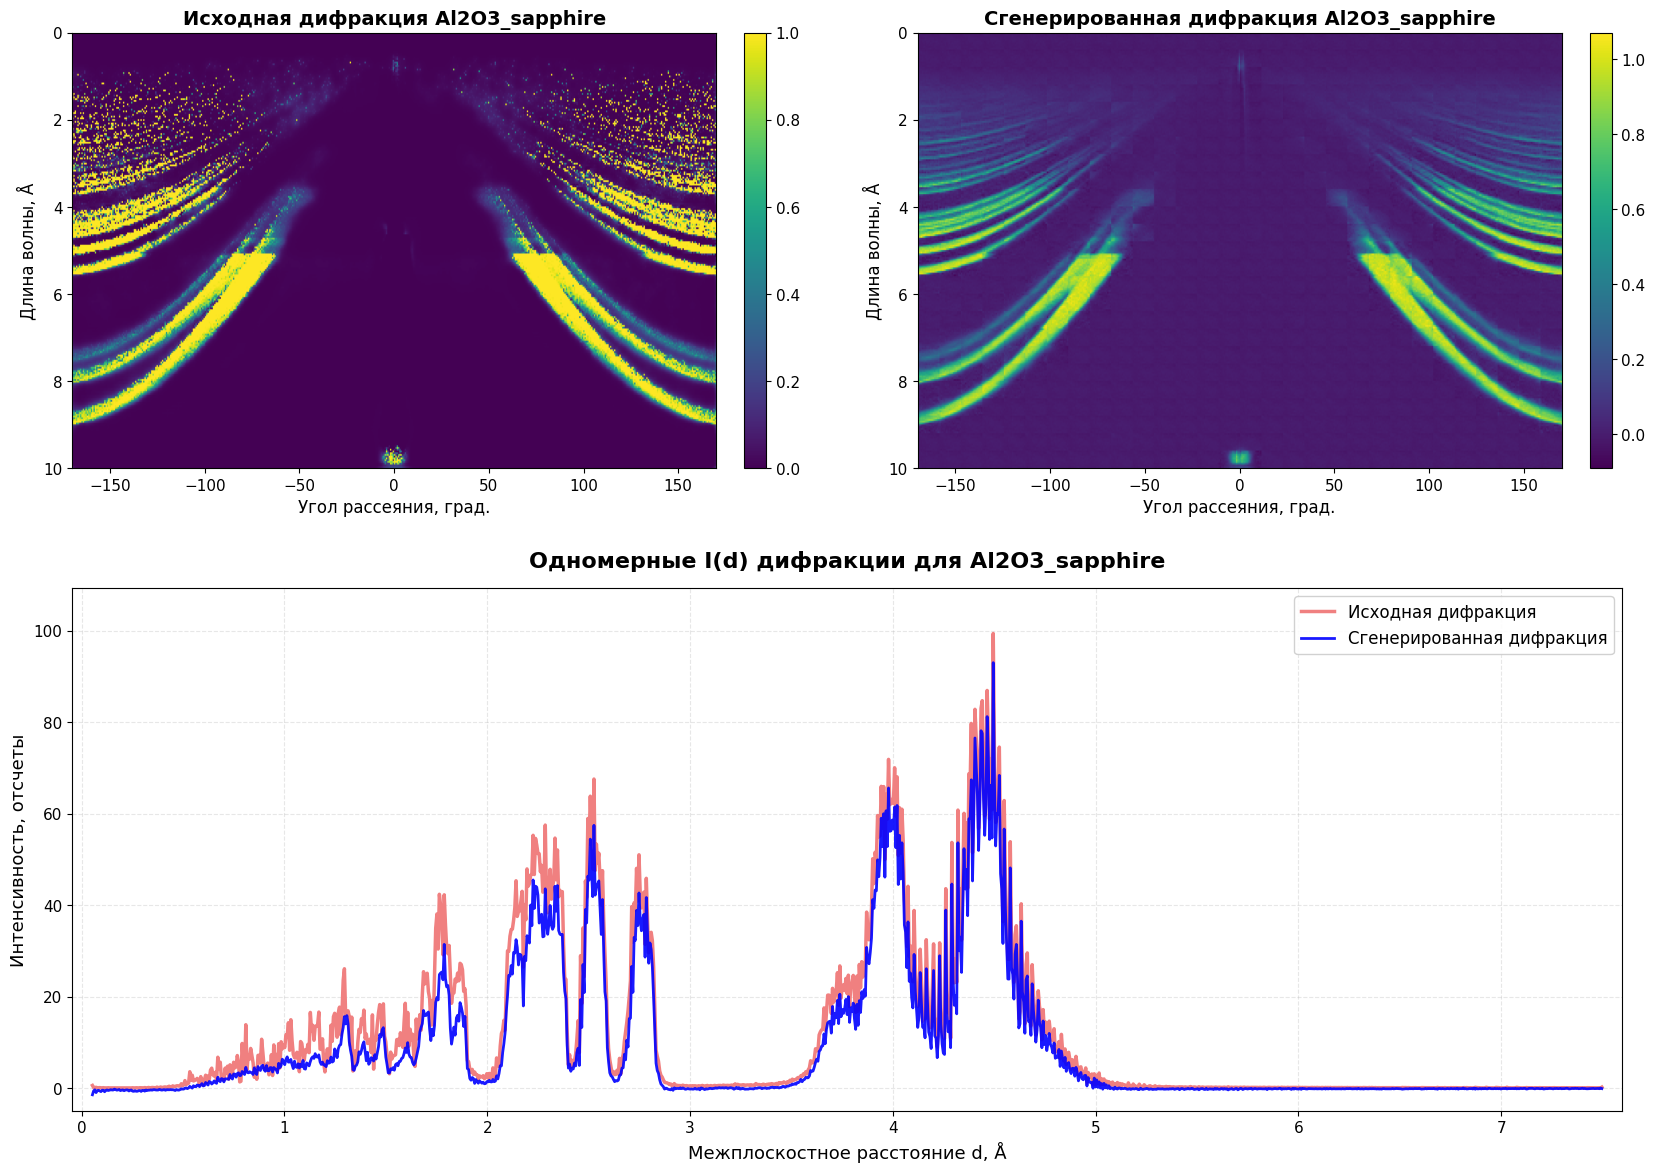

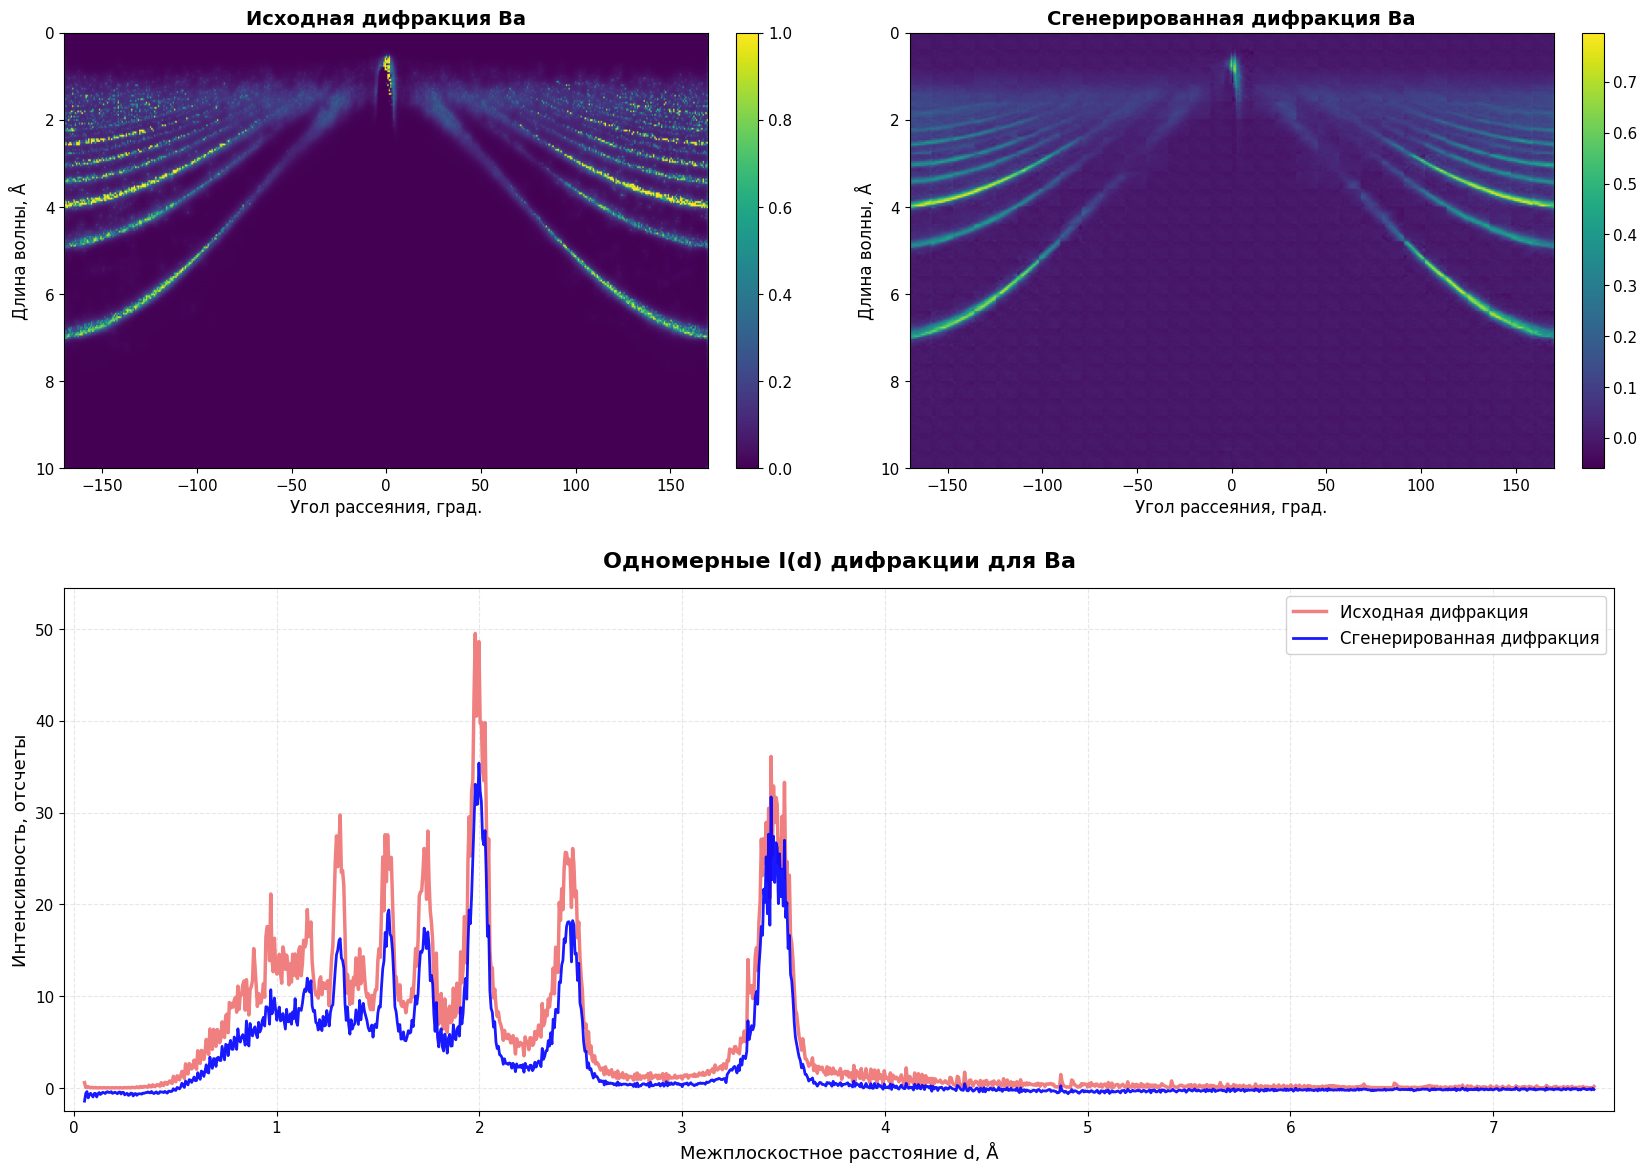

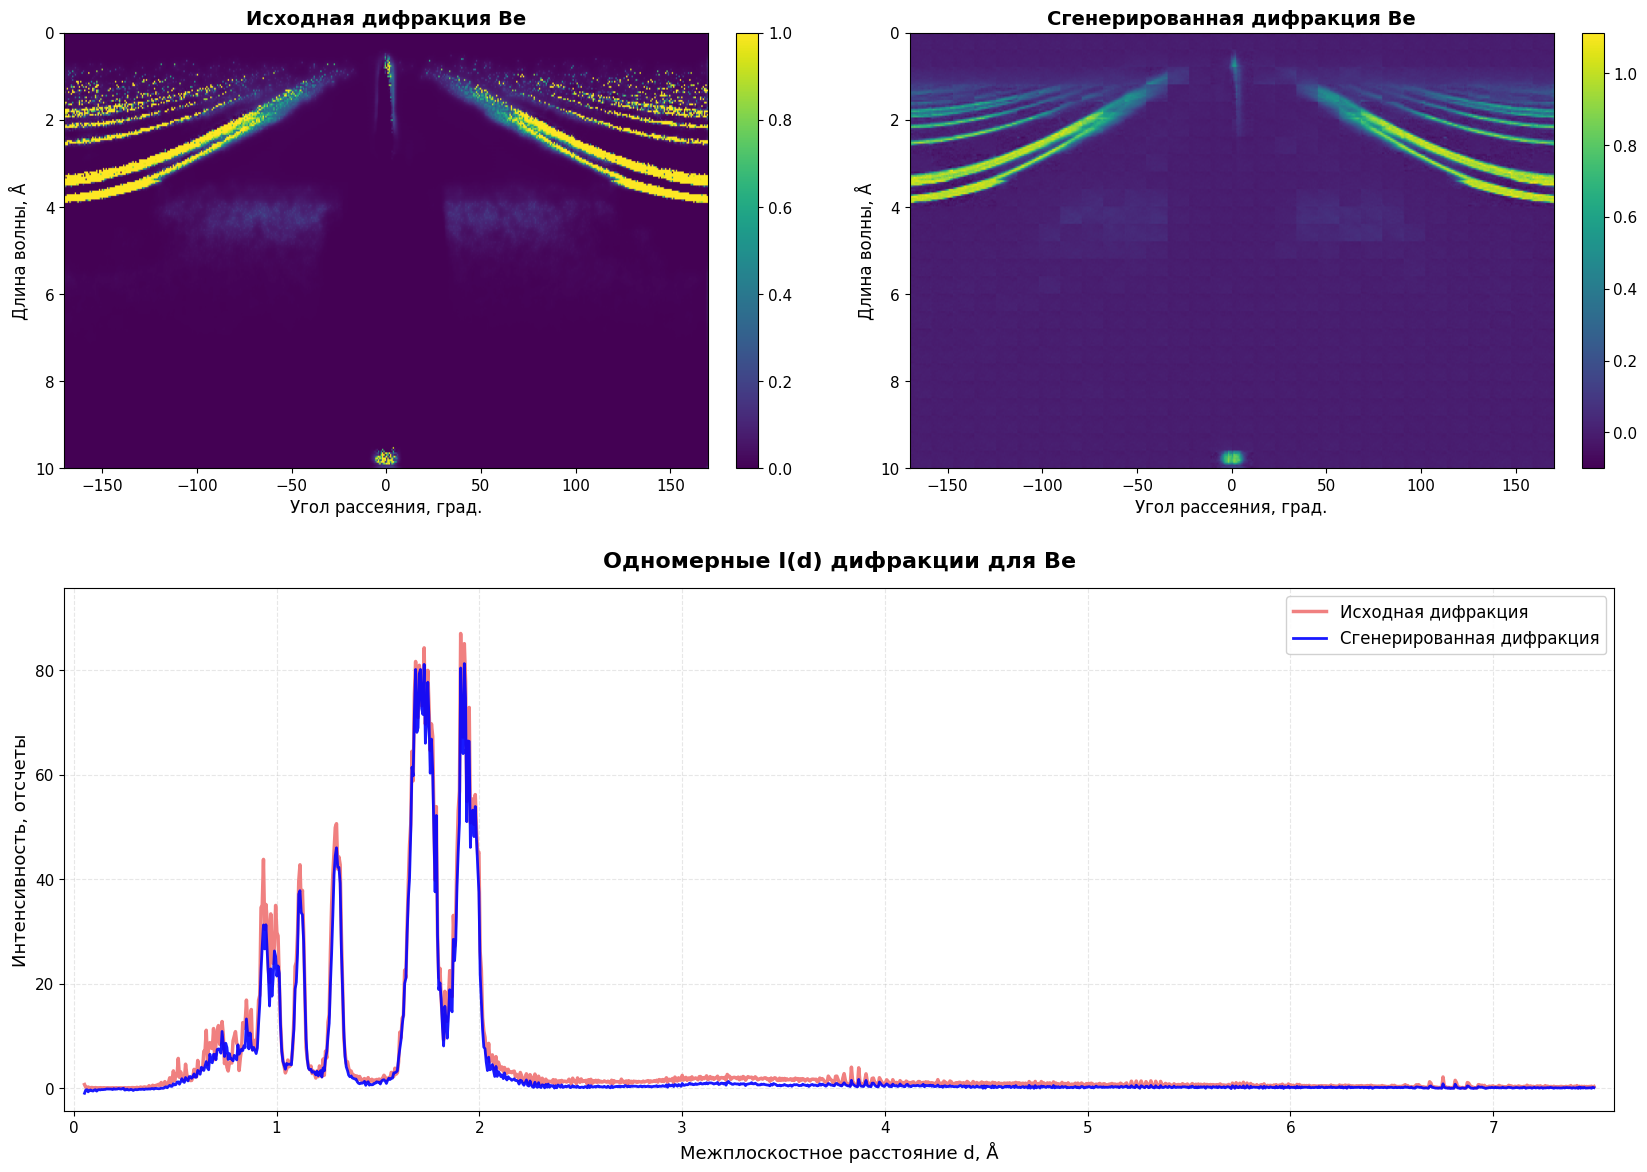

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def denorm(x):
    return (x + 1) / 2

fixed_centers = np.linspace(0.05318052, 7.49710258, 1241)

qw = Qwrapper(
    theta_range=(-170, 170),
    L_range=(0.1, 10),
    fixed_centers=fixed_centers,
    device="cpu"
)

denorm_generated = denorm(generated)
denorm_df_test_tensor = denorm(df_test_tensor)

out_GT = qw.tensor_to_d(denorm_df_test_tensor)
out_generated = qw.tensor_to_d(denorm_generated)

generated_diffractions = denorm_generated.squeeze().cpu().numpy()
gt_diffractions = denorm_df_test_tensor.squeeze().cpu().numpy()

# Устанавливаем параметры шрифтов для всего
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11
})

for i, (generated_diffraction, gt_diffraction) in enumerate(zip(generated_diffractions, gt_diffractions[:4])):
    # Создаем фигуру с 2 строками (верх - 2 колонки, низ - 1 колонка)
    fig = plt.figure(figsize=(20, 14))
    
    # Создаем сетку: 2 строки, 2 колонки для верхнего ряда
    # И 1 ячейка для нижнего ряда, которая занимает обе колонки
    gs = plt.GridSpec(2, 2, height_ratios=[1, 1.2], hspace=0.25, wspace=0.2)
    
    # Верхние хитмапы (занимают верхний ряд, 2 колонки)
    ax1 = plt.subplot(gs[0, 0])  # Левый хитмап
    ax2 = plt.subplot(gs[0, 1])  # Правый хитмап
    
    # Нижний график (занимает нижний ряд, обе колонки)
    ax3 = plt.subplot(gs[1, :])  # Растягиваем на всю ширину
    
    # Первый хитмап (GT)
    im1 = ax1.imshow(gt_diffraction, cmap='viridis', aspect='auto', 
                     extent=(-170, 170, 10, 0))
    ax1.set_title(f"Исходная дифракция {Crystal_tags.tolist()[i]}", fontsize=14, fontweight='bold')
    ax1.set_xlabel('Угол рассеяния, град.', fontsize=12)
    ax1.set_ylabel('Длина волны, Å', fontsize=12)
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Второй хитмап (Generated)
    im2 = ax2.imshow(generated_diffraction, cmap='viridis', aspect='auto', 
                     extent=(-170, 170, 10, 0))
    ax2.set_title(f"Сгенерированная дифракция {Crystal_tags.tolist()[i]}", fontsize=14, fontweight='bold')
    ax2.set_xlabel('Угол рассеяния, град.', fontsize=12)
    ax2.set_ylabel('Длина волны, Å', fontsize=12)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Нижний график с двумя кривыми
    ax3.plot(out_GT[i]["d"], out_GT[i]["I"], label='Исходная дифракция', 
             color='lightcoral', linewidth=2.5)
    ax3.plot(out_generated[i]["d"], out_generated[i]["I"], label='Сгенерированная дифракция', 
             color='blue', linewidth=2, alpha=0.9)
    
    ax3.set_title(f'Одномерные I(d) дифракции для {Crystal_tags.tolist()[i]}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax3.set_xlabel('Межплоскостное расстояние d, Å', fontsize=13)
    ax3.set_ylabel('Интенсивность, отсчеты', fontsize=13)
    
    # Настраиваем легенду
    ax3.legend(fontsize=12, loc='upper right', framealpha=0.9)
    
    # Настраиваем сетку
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    # Настраиваем пределы осей для лучшей видимости
    ax3.set_xlim([min(out_GT[i]["d"].min(), out_generated[i]["d"].min()) - 0.1,
                  max(out_GT[i]["d"].max(), out_generated[i]["d"].max()) + 0.1])
    
    # Автоматическое масштабирование по Y с небольшим запасом
    y_max = max(out_GT[i]["I"].max(), out_generated[i]["I"].max())
    ax3.set_ylim([-0.05 * y_max, 1.1 * y_max])
    
    plt.tight_layout()
    
    # Сохранение (раскомментировать при необходимости)
    # plt.savefig(f'VAE Results/{Crystal_tags.tolist()[i]}_Diffraction_Comparison.jpg', 
    #             dpi=300, bbox_inches='tight')
    
    plt.show()